                          Departamento de Computación
                  Facultad de Ciencias Exactas y Naturales
                         Universidad de Buenos Aires
         
                         Simulación de Eventos Discretos, 2022
                         
 Tarea-2: Majority rule Cell-DEVS with cellular automata.
 
           Martin Carreiro; Matias Grynberg Portnoy; Enaide maine Calzado

Majority rule

Los procesos dinámicos que evolucionan de acuerdo con la regla de la mayoría surgen
en varios entornos y, como tales, han recibido una gran atención en la literatura 
internacional, principalmente  para explorar y resolver diversos problemas, como una especificación de circuito universal [1,2], una especificación de memoria para obtener comportamientos complejos [3-5], o para resolver problemas de clasificación por densidad [6-9]. Aqui nosotros consideramos quizas el caso mas básico, el de la simulación dinámica de los autómatas celulares con la regla de la "mayoría" local.

En nuestro sistema cada celda toma uno de los estados discretos finitos y simultáneamente cambia a un estado que es más común dentro de su vecindad local. El comportamiento que generalmente se observa en este modelo es la formación de un patrón irregular que se vuelve más grueso con el tiempo, hasta que los límites entre áreas de diferentes estados se vuelven lo suficientemente rectos. Esta regla es tan simple que se puede generalizar fácilmente a varios entornos, como espacios multidimensionales, estados múltiples, tamaño de vecindad más grande, etc. 

A nuestro modelo le agregamos un poco de dinamica extra, para realizar una mayor compresion del mismo:
- El delay que en la aplicacion de la regla es aleatorio
- La regla solo se aplica probabilisticamente (approval_rate)
 
 Por otro lado nos planteamos algunas preguntas como:
- ¿Bajo que condiciones iniciales llegamos a un estado comun entre todas las celdas?
- ¿Como se comporta el sistema para ciertas configuraciones iniciales?
- ¿Como afecta el ratio de la aplicacion de la regla a el tiempo de convergencia?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randrange, uniform
import PIL
plt.rcParams["figure.figsize"] = (20,10)

Para la inicialización del modelo, es necesario configurar el path de la carpeta SED_HOME y el BIN, para la simulacion del CD++. 

In [161]:
from pathlib import Path

SED_HOME = Path.home().joinpath('Documents').joinpath('sed')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

CDPP_EXAMPLES_CELL = CDPP_EXAMPLES.joinpath('cell-devs')
CDPP_BIN = BASE_BIN.joinpath('cd++')
DRAWLOG_BIN = BASE_BIN.joinpath('drawlog')

majority_folder = str(CDPP_EXAMPLES)+"/dc-sed-tp2-2022"
majority_folder

'/home/seduser/Documents/sed/CDPP/examples/dc-sed-tp2-2022'

In [162]:
majority_folder = "/home/seduser/Escritorio/SED/CDPP_ExtendedStates-codename-Santi/examples/cell-devs/dc-sed-tp2-2022"

In [163]:
BASE_BIN = "/home/seduser/Escritorio/SED/CDPP_ExtendedStates-codename-Santi/src/bin"

### Funciones

In [164]:
def run_majority():
    command = str(BASE_BIN) + "/cd++ -m majority.ma -l logs/majority.log -t 00:32:00:000 > delete.out" 
    os.system(command)  

In [165]:
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

In [166]:
def numpy_arrays_from_log(rows, columns):
    log_path= majority_folder + "/logs/majority.log01"
    with open(log_path) as f:
        lines = f.readlines()
    lines = list(filter(lambda x : "out" in x, lines))
    times = list(map(lambda x : time_to_secs((x.split("/")[3])), lines))
    values = list(map(lambda x : float((x.split("/")[6]).strip()), lines))
    positions = list(map(lambda x : (x.split("/")[4].split("(")[1].split(")")[0]).split(","), lines))
    positions = list(map(lambda x : (int(x[0]), int(x[1]) ), positions) )

    current_values = np.array(values[:rows*columns]).reshape((rows, columns))
    current_t = times[0]
    grids = []
    for t, v, pos in zip(times,values,positions):
        if current_t != t:
            current_t = t
            grids.append(np.copy(current_values))
        i, j = pos
        current_values[i][j] = v
    grids.append(current_values)

    return grids

In [167]:
def get_global_vote_series(grids):
    return [np.mean(x) for x in grids]

In [168]:
def set_model_grid_size(rows, columns):
    ma_path= majority_folder + "/majority.ma"

    with open(ma_path, 'r') as file:
        lines = file.readlines()
    dim_ind = filter( lambda x: "dim : " in x[1], enumerate(lines))
    dim_ind = next(map(lambda x: x[0], dim_ind))
    lines[dim_ind] = "dim : (" + str(rows) + "," + str(columns) + ")\n"
    with open(ma_path, 'w') as file:
        file.writelines( lines )

In [169]:
def set_approval_rate(approval_rate):
    ma_path= majority_folder + "/majority.ma"

    with open(ma_path, 'r') as file:
        lines = file.readlines()
    rules = filter( lambda x: "rule : " in x[1], enumerate(lines))
    for line,rule in rules:
        for i,char in reversed(list(enumerate(rule))):
            if char == "<":
                rule = rule[0:i+2] + f'{approval_rate}' + '}\n'
                break
        lines[line] = rule
    with open(ma_path, 'w') as file:
        file.writelines( lines )

In [170]:
def set_model_max_delay(max_delay):
    ma_path= majority_folder + "/majority.ma"

    with open(ma_path, 'r') as file:
        lines = file.readlines()
        
    res = []
    for line in lines:
        if "100" in line:
            i = line.index("100")
            i += 4
            j = i
            while line[j] != ")":
                j += 1
            current_delay = line[i:j]
            
            line = line[:i] + str(max_delay) + line[j:]
        res.append(line)
            
    with open(ma_path, 'w') as file:
        file.writelines( res )

In [171]:
def initial_val_generator(rows, columns, p=0.5):
    val_path= majority_folder + "/majority.val"
    lines = []
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  int(uniform(0,1) > p)
            lines.append(pos + str(val) + "\n")

            # lines.append(pos + "[" + str(val) + ",0]" + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )

In [172]:
def line_val_generator(rows, columns, p=0.9):
    val_path= majority_folder + "/majority.val"
    lines = []
    last_val = 1
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  last_val if uniform(0,1) > p else abs(1-last_val)
            lines.append(pos + str(val) + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )

In [173]:
from PIL import Image

def create_collage(case_name, width, height, listofimages, times, max_size):
    all_white = (255, 255, 255)
    new_im = Image.new('RGB', (width, height), all_white)
    ims = []
    for p in listofimages:
        im = Image.open(p)
        im = im.convert("RGBA")
        new_size = int(uniform(5,max_size))
        im = im.resize((new_size, new_size))
        
        datas = im.getdata()

        newData = []
        for item in datas:
            if item[0] == 255 and item[1] == 255 and item[2] == 255:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
                
        ims.append(im)
    for i in range(times):
        img_random = int(uniform(0,len(ims)))
        x_random = int(uniform(0,width))
        y_random = int(uniform(0,width))
        new_im.paste(ims[img_random], (x_random, y_random), ims[img_random])

    new_im.save(f"images/collage_{case_name}.png")

In [174]:
def get_clusters(grid):
    rows, columns = grid.shape[0], grid.shape[1]
    not_seen = set()
    for i in range(rows):
        for j in range(columns):
            not_seen.add((i,j))
            
    
    clusters = []
    n_clusters = 0
    
    while len(not_seen) > 0:
        current_cluster = set()
        i, j = not_seen.pop()
        current_color = grid[i][j]
        visited = set()
        to_search = {(i,j)}
        
        while len(to_search) > 0:
            i, j = to_search.pop()
            
            if (i,j) in visited:
                continue
            
            visited.add((i,j))
            
            if current_color == grid[i][j]:
                current_cluster.add((i,j))
                
                for di, dj in [(0,-1),(0,1),(1,0),(-1,0)]:
                    to_search.add(((i+di)%rows, (j+dj)%columns))
                    
        clusters.append(current_cluster)
        n_clusters += 1
        not_seen = not_seen - current_cluster
    
    return n_clusters

In [175]:
def from_image(path, resize=(40,40)):
    im = (PIL.Image.open(path))
    im = im.resize(resize)
    im = np.asarray(im)
    im = np.mean(im,axis=2)
    im = im >124 # ligeramente mas bajo para que se vea mejor
    #im = im > np.mean(im)
    return im

def grid_to_val(grid):
    val_path= majority_folder + "/majority.val"
    lines = []
    rows = grid.shape[0]
    columns = grid.shape[1]
    for i in range(rows):
        for j in range(columns):
            pos = "(" + str(i) + "," + str(j) + ") = "
            val =  grid[i][j] * 1.0
            lines.append(pos + str(val) + "\n")

    with open(val_path, 'w') as file:
        file.writelines( lines )
        
def img_to_val(path, resize=(40,40)):
    grid_to_val(from_image(path, resize=resize))

### Configuraciones aleatorias

Probamos primero usando configuraciones inicales aleatorias donde cada celda es independiente. Es decir, al momento de construir la grilla inicial seteamos a 0 con probabilidad $p$ y a 1 con probabilidad $1-p$. Para estos experimentos dejamos fijo la probabilidad de aplicar la regla en 70% y el delay de aplicar las reglas en una uniforme entre 100 y 200

Una corrida con $p=0.5$

In [176]:
rows = 40
colums = 40

In [177]:
set_model_grid_size(rows,columns)
initial_val_generator(rows, columns)
set_approval_rate(0.7)
set_model_max_delay(200)
run_majority()

In [178]:
grids = numpy_arrays_from_log(rows,columns)


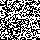

In [179]:
import base64
from IPython.core.display import HTML

imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
imgs[0].save(fp="images/run.gif",format="GIF", append_images=imgs,  duration=37, save_all=True, loop=0)

b64 = base64.b64encode(open("images/run.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Podemos ver que el porcentaje de cada clase cambia muy poco/lentamente. Al final de la simulacion se ve un aumento del 4%. Sin embargo el numero de clusters disminuye fuertemente

Text(0, 0.5, 'fraccion de 1s')

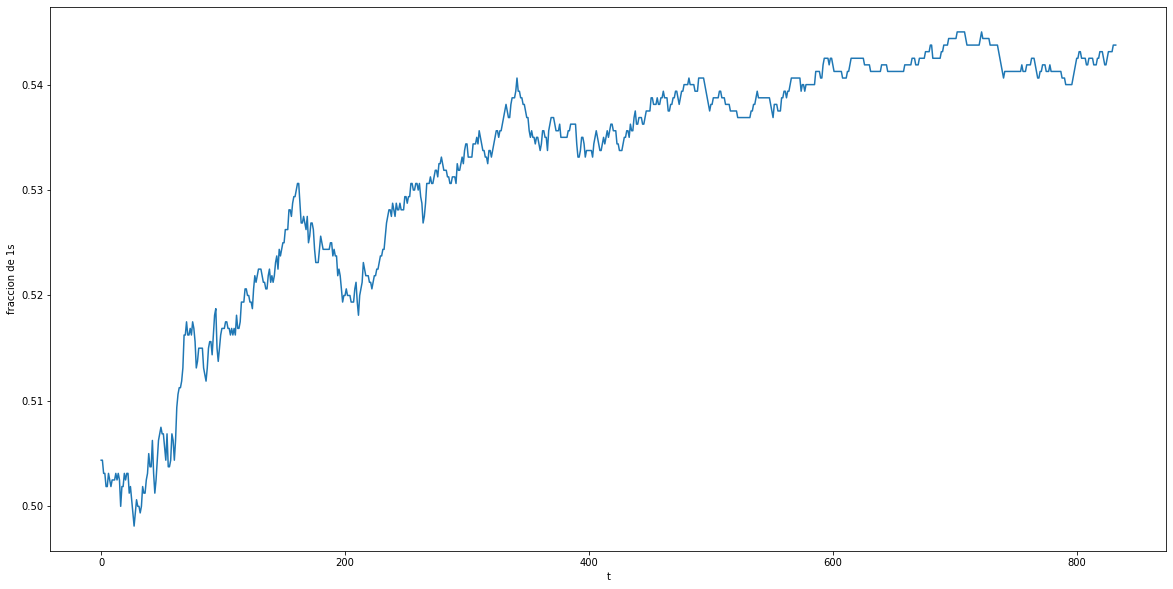

In [180]:
plt.plot(get_global_vote_series(grids))
plt.xlabel("t")
plt.ylabel("fraccion de 1s")


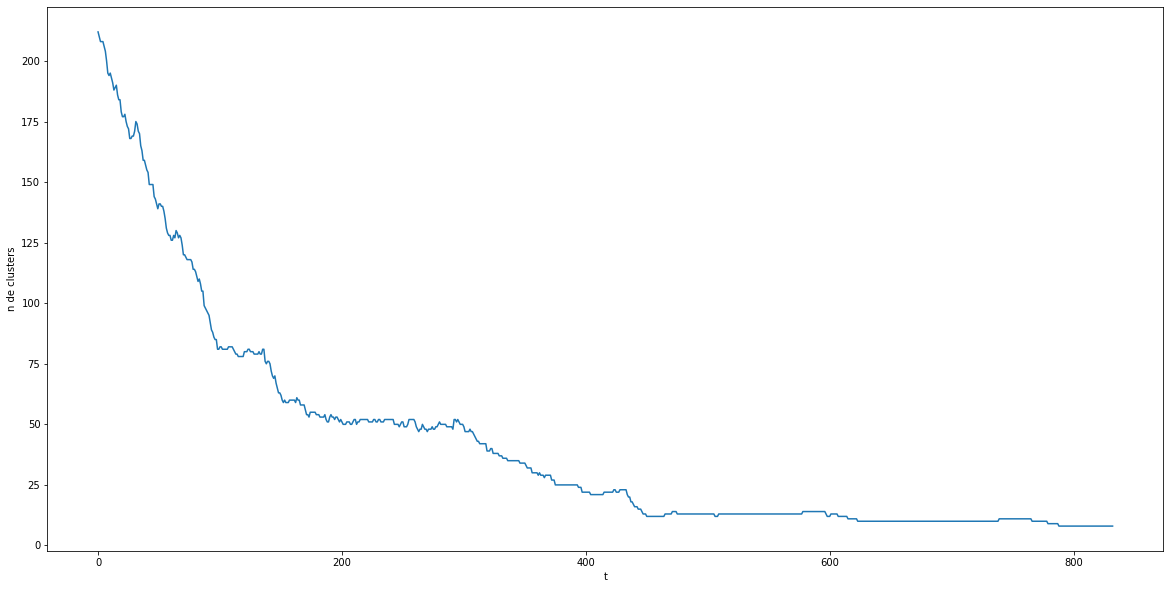

In [181]:
clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
plt.xlabel("t")
plt.ylabel("n de clusters")
plt.plot(clusters)

Mas general, podemos ver como se comporta con distintos $p$. Vemos que ya con un pequeño desbalance se llega a un punto estable mucho mas rapido y una diferencia mas marcada. En el caso de 60% de 1s incialmente se llega a alrededor del 90%. 

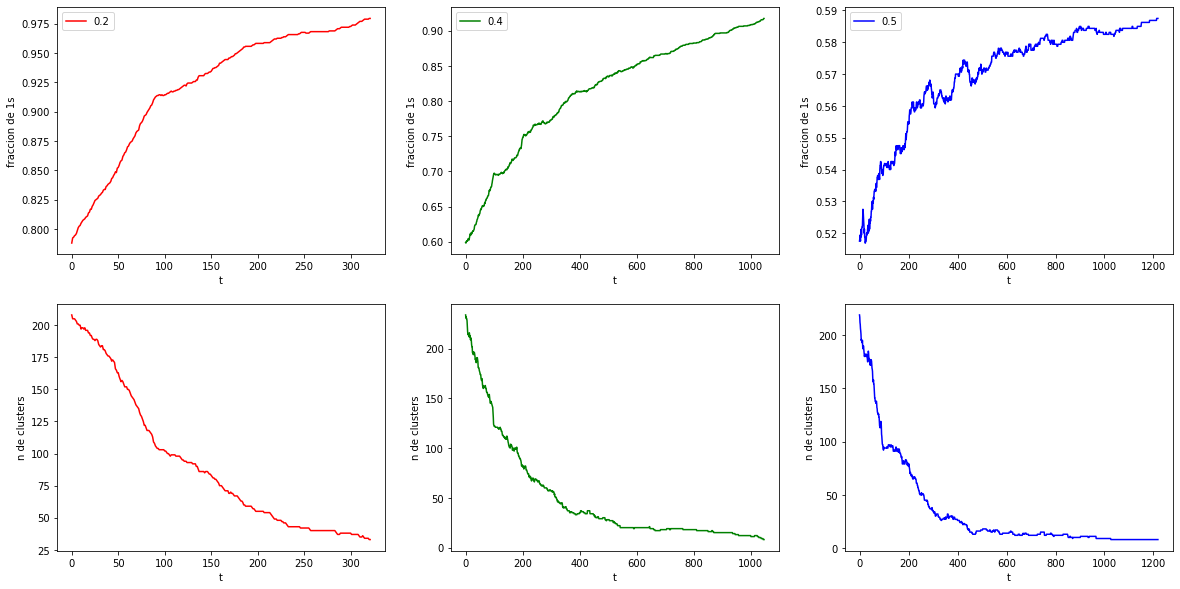

In [184]:
ps = [0.2, 0.4, 0.5]
colors = ["red", "green", "blue"]
fig, axs = plt.subplots(2, len(ps))
set_approval_rate(0.7)
set_model_max_delay(200)

for i, x in enumerate(zip(ps, colors)):
    p, c = x
    initial_val_generator(rows,columns, p)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    axs[0][i].plot(get_global_vote_series(grids), label=str(p), color=c)
    axs[0][i].legend()
    axs[0][i].set_xlabel("t")
    axs[0][i].set_ylabel("fraccion de 1s")
    
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    axs[1][i].set_xlabel("t")
    axs[1][i].set_ylabel("n de clusters")
    axs[1][i].plot(clusters, label=str(p), color=c)

Tambien nos parecio interesante comparar el ritmo de reduccion de clusters en un solo grafico. Sin embargo, no obtuvimos una relacion entre $p$ y su efecto en la disminucion de clusters.

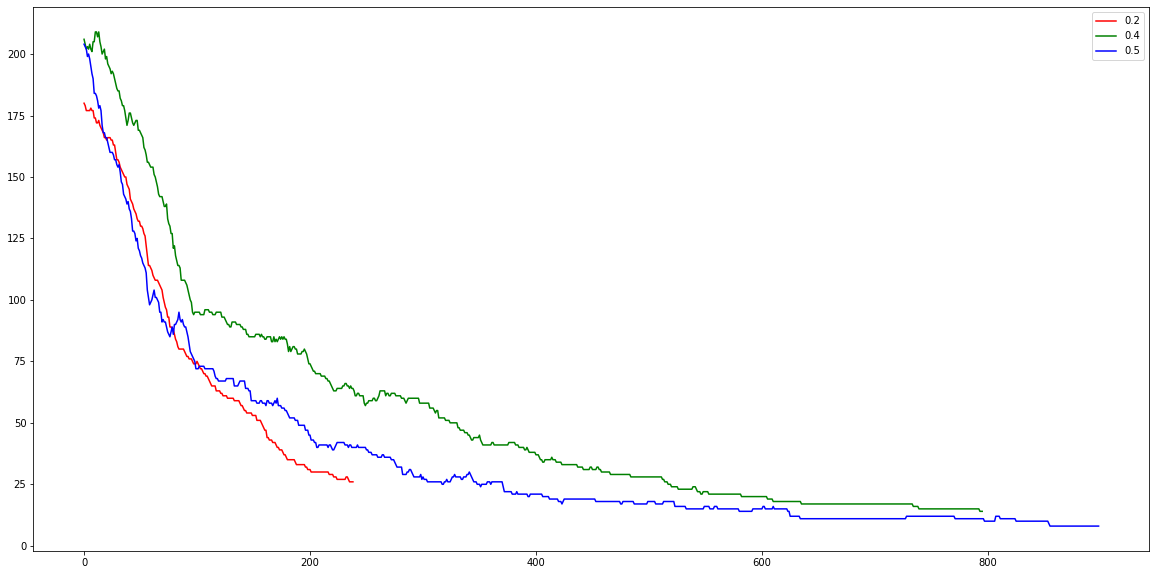

In [185]:
for p, c in zip(ps, colors):
    initial_val_generator(rows,columns, p)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    plt.plot(clusters, label=str(p), color=c)
    plt.legend()

### Un ejemplo con una imagen real

Nos parecio interesante probar como se comporta el modelo cuando se tiene como entrada una imagen real. La idea era aprovechar las estructuras espaciales a diferencia de una generación uniforme

(-0.5, 39.5, 39.5, -0.5)

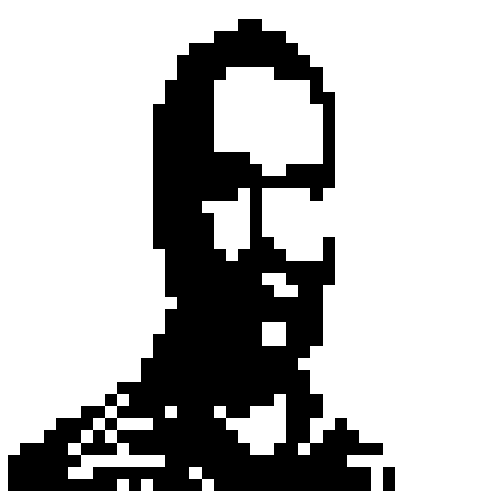

In [187]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=80)

im = from_image("images/Rodrigo-Castro.jpg", (columns,rows))
img_to_val("images/Rodrigo-Castro.jpg", (columns,rows))
plt.imshow(255-im, cmap="Greys")
plt.axis('off')

In [188]:
set_approval_rate(0.7)
set_model_max_delay(200)
run_majority()

In [189]:
grids = numpy_arrays_from_log(rows,columns)


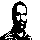

In [190]:
import base64
from IPython.core.display import HTML

imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
imgs[0].save(fp="images/run.gif",format="GIF", append_images=imgs,  duration=37, save_all=True, loop=0)

b64 = base64.b64encode(open("images/run.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Text(0, 0.5, 'fraccion de 1s')

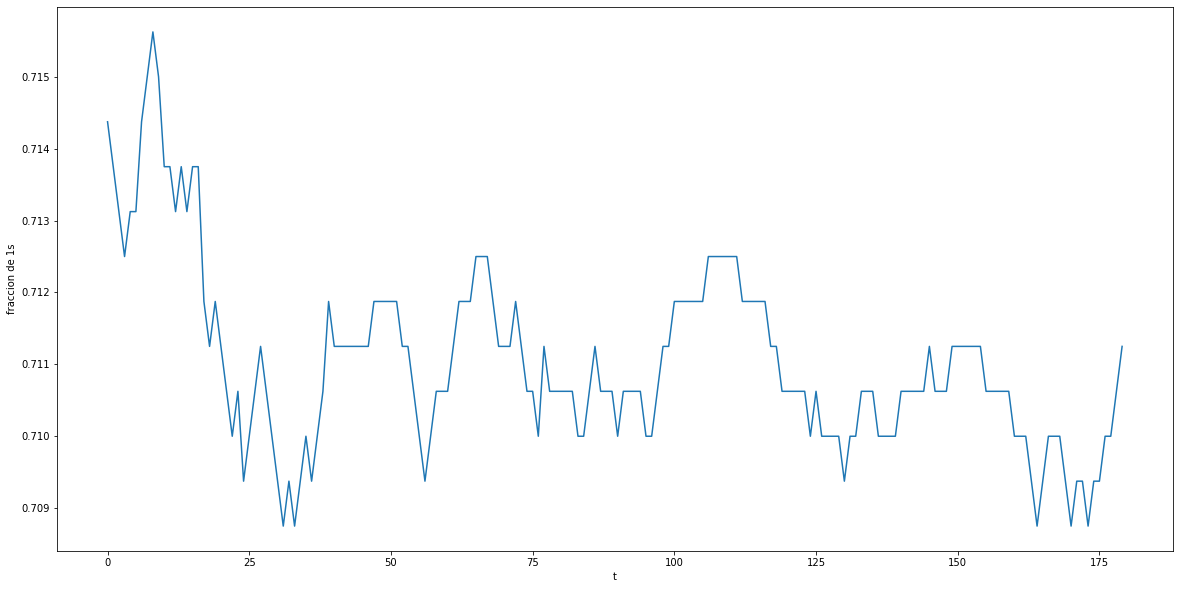

In [191]:
plt.plot(get_global_vote_series(grids))
plt.xlabel("t")
plt.ylabel("fraccion de 1s")

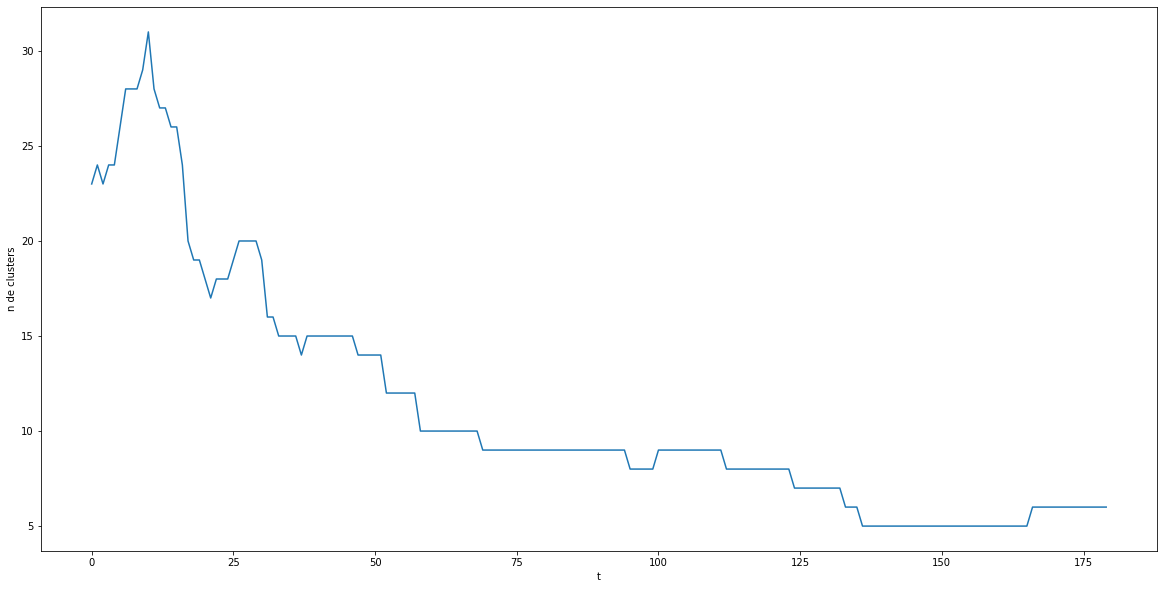

In [192]:
clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
plt.xlabel("t")
plt.ylabel("n de clusters")
plt.plot(clusters)

Curiosamente, aunque la proporcion inical de 1s es de alreredor de 75%, *el sistema no cambia mucho su composocopm original*. Esto quizas esta relacionado con como estan organizadas las imagenes naturales. Donde ya hay grandes clusters desde el principio.

### El efecto del delay variable

Exploramos como impacta el tener un delay variable o no en el comportamiento del sistema. Para ello, modificamos el .ma cambiando la distribucion del delay. Todas las distribuciones son del tipo 
uniform(100,x) con nosotros fijando el x. Para estos experimentos fijamos $p=0.4$

Observamos que para delays fijos la simulacion deja de cambiar mucho antes. En cambio para los delays mayores, la simulacion seguia teniendo cambios cuando se acabo el tiempo de simulacion
Tambien, curiosamente, aunque la simulacion con un delay fijo termina mucho antes, tiene bastantes mas clusters.



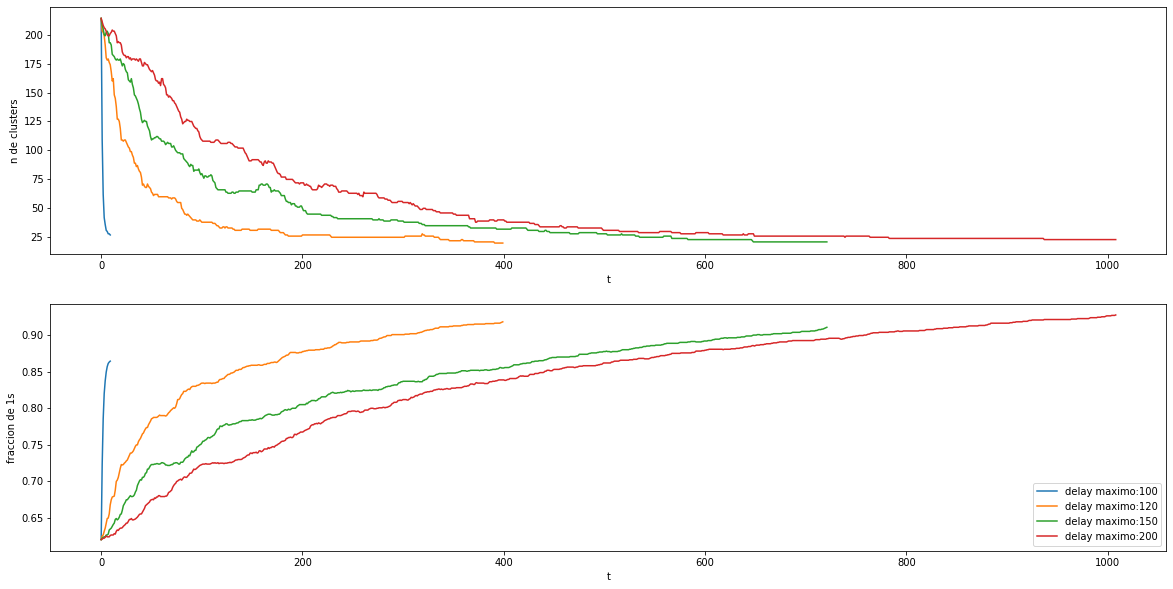

In [193]:
p = 0.4
rows = 40
columns = 40
initial_val_generator(rows,columns, p)
fig, axs = plt.subplots(2 )
set_approval_rate(0.7)

delays = [100,120,150, 200]
for delay in delays:
    set_model_max_delay(delay)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    axs[0].plot(clusters, label="delay maximo:" + str(delay))
    axs[1].plot(get_global_vote_series(grids), label="delay maximo:" + str(delay))
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("n de clusters")
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("fraccion de 1s")
    
    plt.legend()
                          

Para explorar esto del efecto del delay en el numero de clusters final, corremos la simulacion con disintos valores y observamos con cuantos clusters terminan.

In [221]:
p = 0.4
rows = 40
columns = 40
initial_val_generator(rows,columns, p)
set_approval_rate(0.7)

fraccion_finales = []

for delay in range(100, 210, 10):
    set_model_max_delay(delay)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    fraccion_finales.append(clusters[-1])

In [222]:
fraccion_finales

[26, 19, 14, 11, 14, 11, 13, 12, 11, 14, 13]

Text(0, 0.5, 'n de clusters finales')

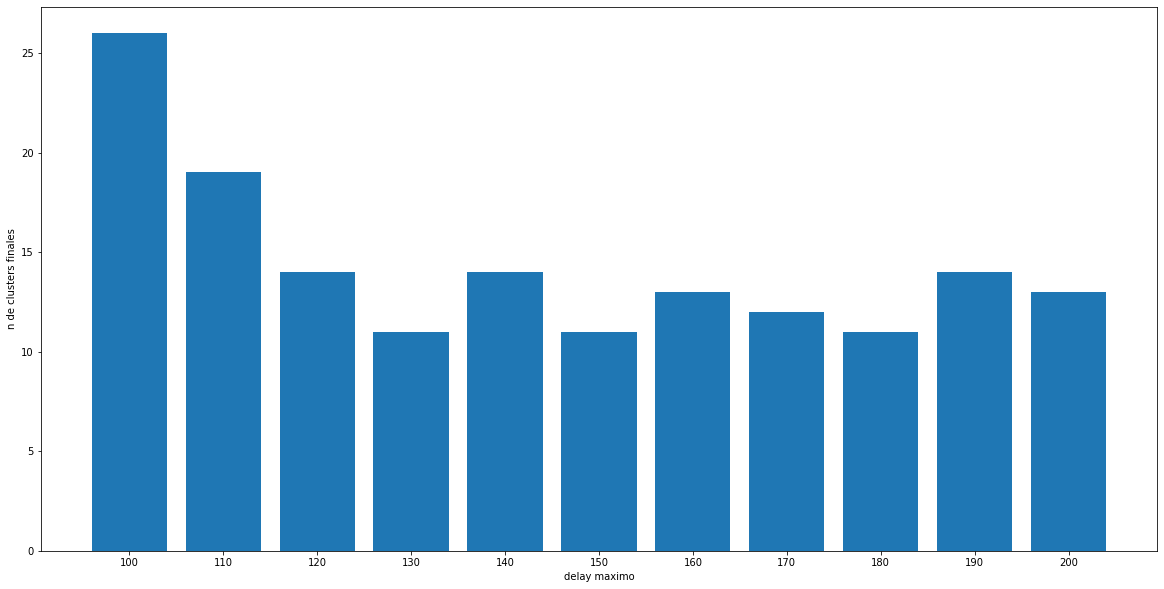

In [223]:
plt.bar(range(len(fraccion_finales)), fraccion_finales)
plt.xticks(range(len(fraccion_finales)), range(100,210,10))
plt.xlabel("delay maximo")
plt.ylabel("n de clusters finales")

### Modificando el approval rate

La siguiente prueba define el max_delay = 200 y una probabilidad de 1s = 0.6. Queremos experimentar con distintos approval_rates. La hipótesis es que a medida que las personas son más reticentes al cambio y a aceptar la mayoría se generan desacuerdos.

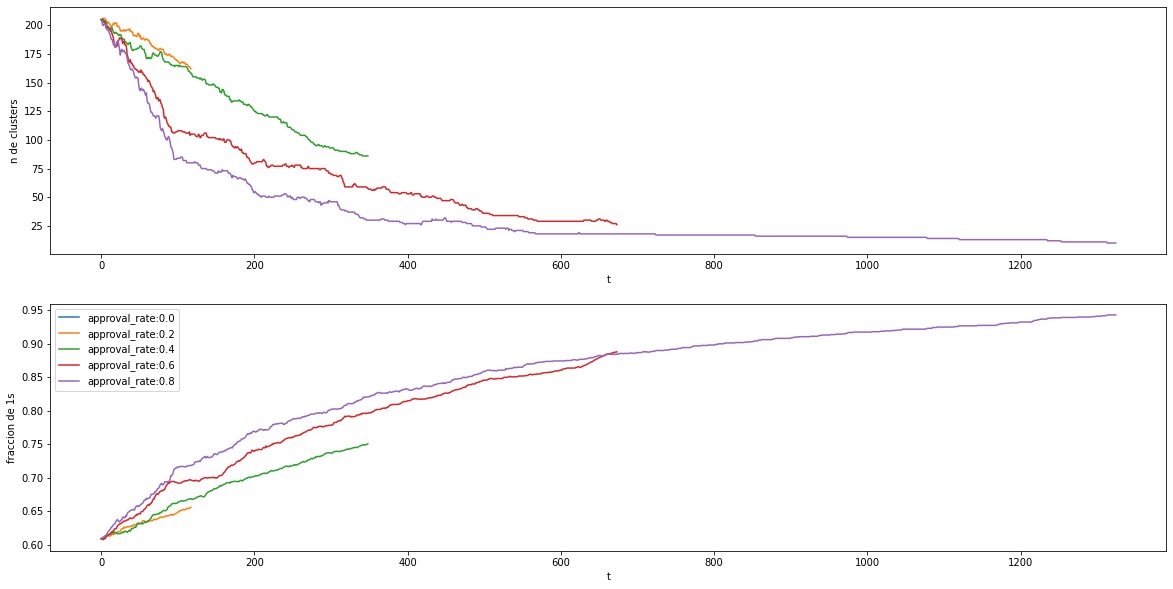

In [196]:
p = 0.4
rows = 40
columns = 40
initial_val_generator(rows,columns, p)
set_model_max_delay(200)

fraccion_finales = []

fig, axs = plt.subplots(2 )

for approval_rate in range(0, 10, 2):
    approval_rate = approval_rate/10.0
    set_approval_rate(approval_rate)
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    fraccion_finales.append(clusters[-1])
    axs[0].plot(clusters, label="approval_rate:" + str(approval_rate))
    axs[1].plot(get_global_vote_series(grids), label="approval_rate:" + str(approval_rate))
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("n de clusters")
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("fraccion de 1s")

    imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
    imgs[0].save(fp=f"images/run_approval_rate_{str(approval_rate)}.gif",format="GIF", append_images=imgs,  duration=37, save_all=True, loop=0)   

    plt.legend()

Text(0, 0.5, 'n de clusters finales')

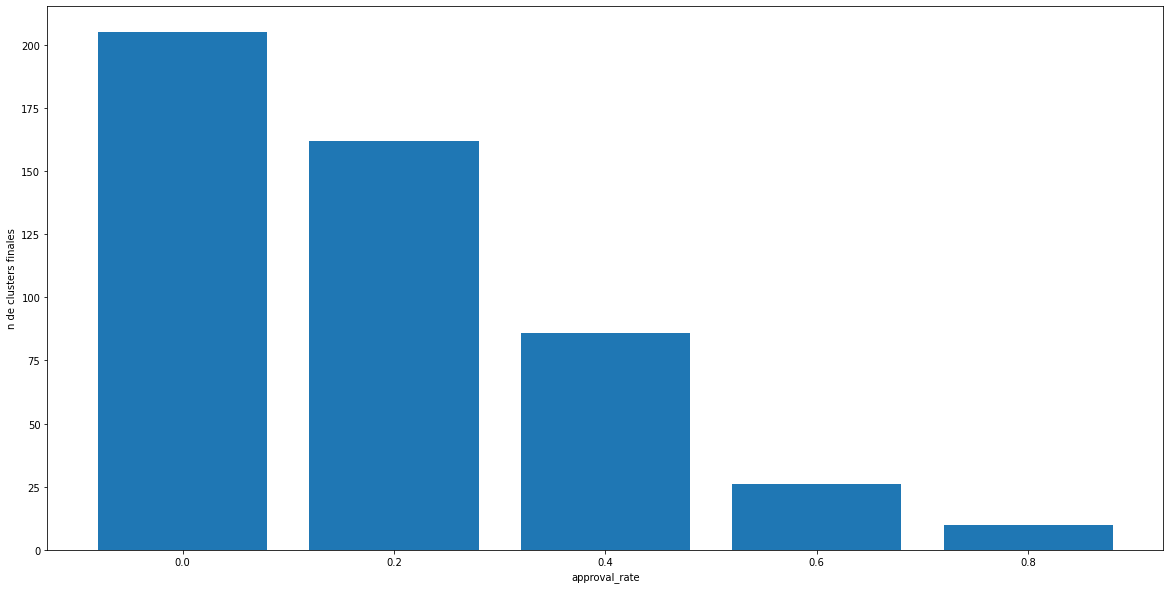

In [197]:
plt.bar(range(len(fraccion_finales)), fraccion_finales)
plt.xticks(range(len(fraccion_finales)), [str(x/10.0) for x in range(0,10,2)] )
plt.xlabel("approval_rate")
plt.ylabel("n de clusters finales")


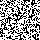

In [198]:
import base64
from IPython.core.display import HTML
b64 = base64.b64encode(open("images/run_approval_rate_0.2.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))


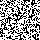

In [199]:
import base64
from IPython.core.display import HTML
b64 = base64.b64encode(open("images/run_approval_rate_0.8.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Confirmamos la hipotesis y notamos como muy rapidamente se van armando los pocos clusters que esperamos. Igualmente notamos una demora en el desarmado de los pequeños clusters. Este caso puede modelar como algunas ideas si bien se pueden deshacer en su mayoría, igualmente deshacernos de ellas cuesta por más alto que sea el approval (acceptance) rate.

También es interesante notar como deja de haber cambios en función de la probabilidad de aceptación. En el momento que ningún individuo cambia de parecer, el sistema se estabiliza.

### Otra familia de inputs
En vez de experimentar con decisiones individuales en la generación del estado inicial, armamos distintos tipos de clusters a partir de formas geométricas para ver cómo se comporta bajo distintos bordes de clusters.

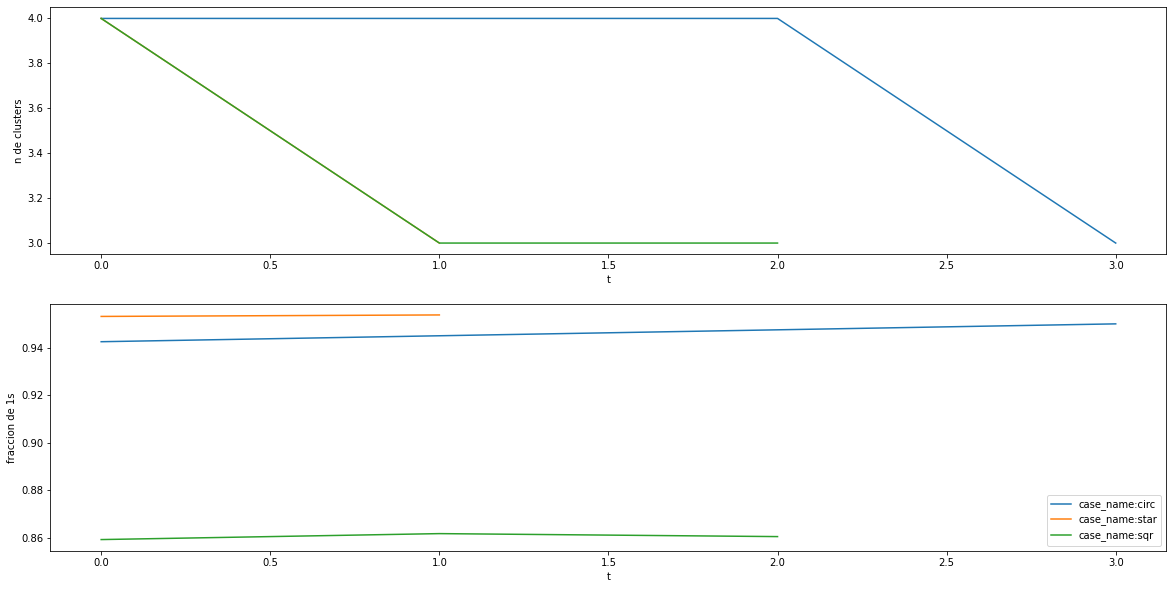

In [213]:
p = 0.4
rows = 40
columns = 40
initial_val_generator(rows,columns, p)
set_model_max_delay(100)
set_approval_rate(1)

fraccion_finales = []

fig, axs = plt.subplots(2 )

images = ['images/circle.png','images/star.png', 'images/square.png']
images_names = ['circ','star', 'sqr']

for max_img_ind in range(1, 4, 1):
    possible_images = images[max_img_ind-1:max_img_ind]
    case_name = "-".join(images_names[max_img_ind-1:max_img_ind])
    #create_collage(case_name, columns, rows, possible_images, 3, 20)
    img_to_val(f"images/collage_{case_name}.png", (rows, columns))
    run_majority()
    grids = numpy_arrays_from_log(rows,columns)
    clusters =  [ get_clusters(grids[x]) for x in range(len(grids)) ] 
    fraccion_finales.append(clusters[-1])
    axs[0].plot(clusters, label="case_name:" + str(case_name))
    axs[1].plot(get_global_vote_series(grids), label="case_name:" + str(case_name))
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("n de clusters")
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("fraccion de 1s")

    imgs = [PIL.Image.fromarray(arr*255) for arr in grids]
    imgs[0].save(fp=f'images/run_shape_{case_name}.gif',format="GIF", append_images=imgs,  duration=120, save_all=True, loop=0)   

    plt.legend()


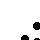

In [214]:
import base64
from IPython.core.display import HTML
b64 = base64.b64encode(open("images/run_shape_circ.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Los circulos tienden a ser inmutables.


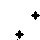

In [215]:
import base64
from IPython.core.display import HTML
b64 = base64.b64encode(open("images/run_shape_star.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Aca es interesante notar como las estrellas tienden a transformarse en circulos. Por lo que se puede predecir el comportamiento. La razón es que las esquinas de las estrellas están rodeadas de 1s.


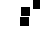

In [216]:
import base64
from IPython.core.display import HTML
b64 = base64.b64encode(open("images/run_shape_sqr.gif",'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" width=350, height=350 />'))

Aunque en menor medida, al igual que el anterior, también se quiere transformar en un círculo. Las reglas buscan en generar bordes curvos.